In [104]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
sst_anoms = xr.open_dataset('./data/SST_anoms.nc')
swe_anoms = xr.open_dataset('./data/SWE_anoms.nc')

swe_by_eco_files = glob.glob('./data/snow_by_eco/*.nc')

In [3]:
for i in range(15):
    print(i, swe_by_eco_files[i])

0 ./data/snow_by_eco/snow_Klamath_Mountains.nc
1 ./data/snow_by_eco/snow_Middle_Rockies.nc
2 ./data/snow_by_eco/snow_Central_Basin_and_Range.nc
3 ./data/snow_by_eco/snow_Blue_Mountains.nc
4 ./data/snow_by_eco/snow_Canadian_Rockies.nc
5 ./data/snow_by_eco/snow_Eastern_Cascades_Slopes_and_Foothills.nc
6 ./data/snow_by_eco/snow_Wasatch_and_Uinta_Mountains.nc
7 ./data/snow_by_eco/snow_Sierra_Nevada.nc
8 ./data/snow_by_eco/snow_North_Cascades.nc
9 ./data/snow_by_eco/snow_Northern_Basin_and_Range.nc
10 ./data/snow_by_eco/snow_Columbia_Mountains_Northern_Rockies.nc
11 ./data/snow_by_eco/snow_Arizona_New_Mexico_Mountains.nc
12 ./data/snow_by_eco/snow_Southern_Rockies.nc
13 ./data/snow_by_eco/snow_Idaho_Batholith.nc
14 ./data/snow_by_eco/snow_Cascades.nc


In [4]:
goa_sst = sst_anoms.sel(lat=slice(50,40), lon=slice(220,230))

In [5]:
goa_sst

<xarray.Dataset>
Dimensions:  (lat: 6, lon: 6, time: 672)
Coordinates:
  * lat      (lat) float32 50.0 48.0 46.0 44.0 42.0 40.0
  * lon      (lon) float32 220.0 222.0 224.0 226.0 228.0 230.0
  * time     (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2019-09-01
Data variables:
    sst      (time, lat, lon) float32 ...

In [6]:
swea_cascades = xr.open_dataset(swe_by_eco_files[-1])

In [7]:
swea_cascades_ts = swea_cascades.mean(dim='sites').dropna(dim='time')

In [8]:
# generate predicted SWE from SST
swe = swea_cascades_ts.to_dataframe()
sst = goa_sst.mean(dim=['lat','lon']).to_dataframe()

In [9]:
df = swe.join(sst)

In [10]:
df = df.dropna()
df = df.reset_index()
# df = df.drop(['lat', 'lon'], axis=1)

df['time'] = df['time'].map(lambda x: x.isoformat())

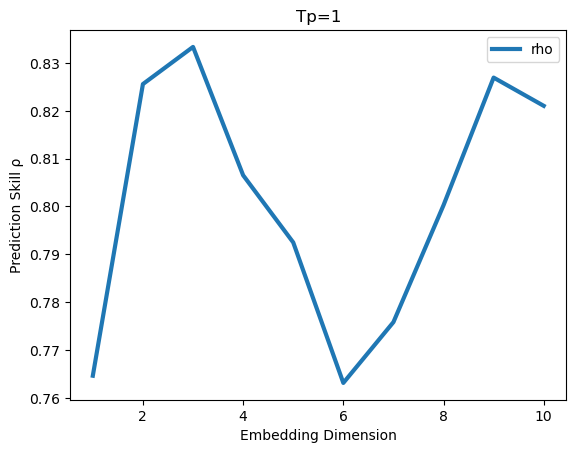

In [11]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

In [12]:
E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

3


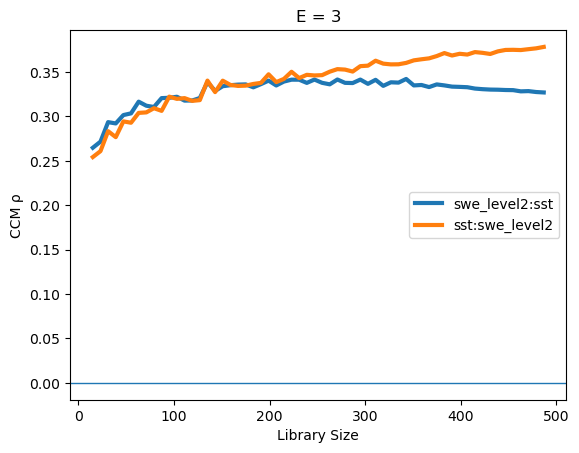

In [13]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

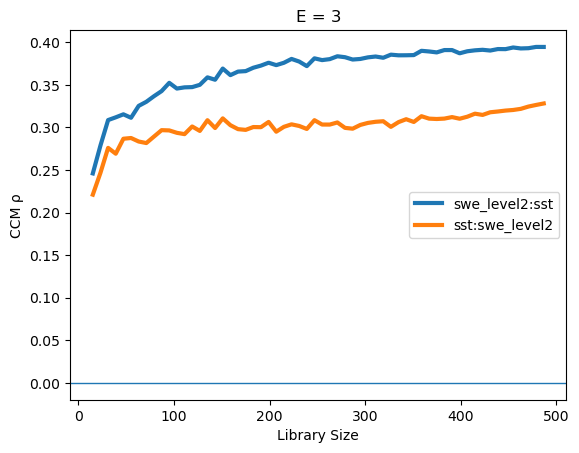

In [14]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

In [98]:
ccm_lag1.

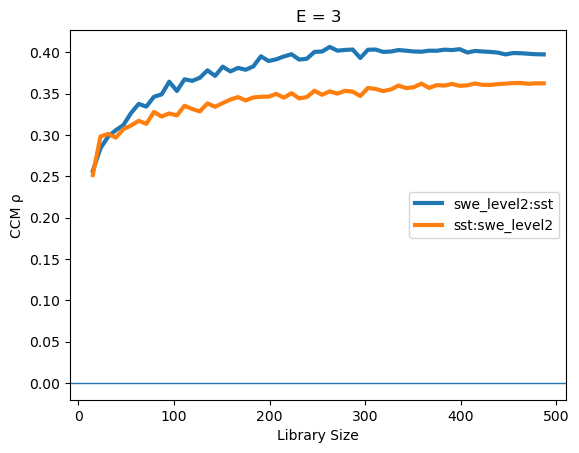

In [15]:
# maxN = L - (E+1)

# df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

In [16]:
ccm_lag1.RevMap.FindNeighbors()
ccm_lag1.RevMap.Project()
ccm_lag1.RevMap.FormatProjection()

ccm_lag1_re = ccm_lag1.RevMap.Projection

In [17]:
ccm_lag3.RevMap.FindNeighbors()
ccm_lag3.RevMap.Project()
ccm_lag3.RevMap.FormatProjection()

ccm_lag3_re = ccm_lag3.RevMap.Projection

In [18]:
ccm_lag6.RevMap.FindNeighbors()
ccm_lag6.RevMap.Project()
ccm_lag6.RevMap.FormatProjection()

ccm_lag6_re = ccm_lag6.RevMap.Projection

In [19]:
# df['CCM-l1'] = ccm_lag1_re
# df['CCM-l3'] = ccm_lag3_re
# df['CCM-l6'] = ccm_lag6_re

In [20]:
ts = swea_cascades_ts.to_array().to_numpy().reshape(-1)

In [21]:
r1, p1 = stats.pearsonr(df['sst'][0:-1], df['swe_level2'][1:])

In [22]:
r3, p3 = stats.pearsonr(df['sst'][0:-3], df['swe_level2'][3:])

In [23]:
r6, p6 = stats.pearsonr(df['sst'][0:-6], df['swe_level2'][6:])

In [107]:
df['sst'][0:-1].to_numpy()

array([ 0.07028238,  0.3869349 ,  0.47446477,  0.474786  ,  0.22654428,
        0.33401978,  0.23854402,  0.3613206 ,  0.2646393 ,  0.30076608,
        0.8650392 ,  0.519116  ,  0.56665826, -0.10993364,  0.02533262,
       -0.01318513,  0.11626206, -0.02335914, -0.16074571, -0.35386932,
       -0.5594976 , -0.6141324 , -0.5908823 , -0.29966205, -0.09857056,
        0.2728675 ,  0.39886206,  0.89831066,  0.6599543 ,  0.38764042,
        0.25241467,  0.2334946 , -0.03746383, -0.26553407,  0.26489952,
       -0.06454261, -0.90379196, -0.12313727, -0.44428816, -0.3912712 ,
       -0.20633553, -0.5031394 , -0.76302135, -0.895483  , -0.58597183,
       -0.64796996, -1.0020049 , -0.29271126, -0.5781693 , -0.649956  ,
       -0.45092022, -0.35221708, -0.14758651,  0.05445774, -0.24488735,
        0.14526923,  0.0833363 , -0.56559676, -0.65813905, -0.8164504 ,
       -0.04660084, -0.14974584, -0.26339048,  0.13512789,  0.286526  ,
        0.38032794,  0.08992139, -0.12455688, -0.5654221 , -0.64

In [127]:
x_train, x_test, y_train, y_test = train_test_split(df['sst'][0:-1].to_numpy(),
                                                    df['swe_level2'][1:].to_numpy(),
                                                    random_state=42)

slope_l1, intercept_l1, r_l1, p_l1, std_err_l1 = stats.linregress(x_train, y_train)
swe_pred1 = slope_l1 * df['sst'][0:-1] + intercept_l1

In [128]:
x_train, x_test, y_train, y_test = train_test_split(df['sst'][0:-3].to_numpy(),
                                                    df['swe_level2'][3:].to_numpy(),
                                                    random_state=42)

slope_l3, intercept_l3, r_l3, p_l3, std_err_l3 = stats.linregress(x_train, y_train)
swe_pred3 = slope_l3 * df['sst'][0:-3] + intercept_l3

In [130]:
x_train, x_test, y_train, y_test = train_test_split(df['sst'][0:-6].to_numpy(),
                                                    df['swe_level2'][6:].to_numpy(),
                                                    random_state=42)

slope_l6, intercept_l6, r_l6, p_l6, std_err_l6 = stats.linregress(x_train, y_train)
swe_pred6 = slope_l6 * df['sst'][0:-6] + intercept_l6

In [157]:
y_p_lag1 = slope_l1 * df['sst'] - intercept_l1
y_p_lag3 = slope_l3 * df['sst'] - intercept_l3
y_p_lag6 = slope_l6 * df['sst'] - intercept_l6

In [158]:
df['y_pred_l1'] = y_p_lag1
df['y_pred_l3'] = y_p_lag3
df['y_pred_l6'] = y_p_lag6

In [159]:
df['dtime'] = df['time'].map(lambda x: datetime.datetime.fromisoformat(x))

In [160]:
df

,time,sst,swe_level2,y_pred,dtime,AR-1,AR-3,AR-6,y_pred_l1,y_pred_l3,y_pred_l6
0,1978-10-01T00:00:00,0.070282,-0.523846,0.023239,1978-10-01,-0.523846,-0.523846,-0.523846,-0.068428,-0.091574,-0.081978
1,1978-11-01T00:00:00,0.386935,-0.582581,-0.095838,1978-11-01,0.107579,-0.582581,-0.582581,-0.186156,-0.192254,-0.167703
2,1978-12-01T00:00:00,0.474465,-0.449708,-0.128754,1978-12-01,0.368313,-0.449708,-0.449708,-0.218699,-0.220085,-0.191400
3,1979-01-01T00:00:00,0.474786,-0.730925,-0.128875,1979-01-01,1.173862,0.488579,-0.730925,-0.218818,-0.220187,-0.191486
4,1979-02-01T00:00:00,0.226544,-0.564041,-0.035523,1979-02-01,0.781752,-0.071057,-0.564041,-0.126525,-0.141258,-0.124282
...,...,...,...,...,...,...,...,...,...,...,...
487,2019-05-01T00:00:00,0.724249,-0.279344,-0.222685,2019-05-01,-0.099214,0.102653,0.051274,-0.311566,-0.299505,-0.259022
488,2019-06-01T00:00:00,1.322131,-0.245479,-0.447518,2019-06-01,-0.247145,0.061193,0.149043,-0.533851,-0.489603,-0.420882
489,2019-07-01T00:00:00,2.194706,-0.271610,-0.775650,2019-07-01,-0.143789,0.296285,-0.155050,-0.858265,-0.767042,-0.657108
490,2019-08-01T00:00:00,2.224361,-0.211882,-0.786801,2019-08-01,-0.194877,-0.160804,0.352078,-0.869290,-0.776471,-0.665136


Text(0.0, 1.0, 'Lag 1')

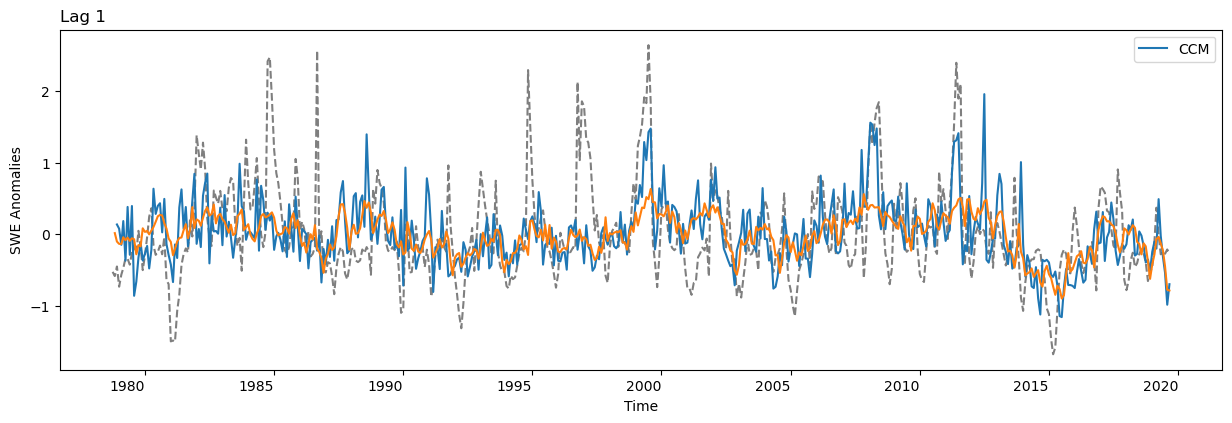

In [161]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['dtime'], df['swe_level2'], ls='--', color='k', alpha=0.5)
# ax.plot(df['dtime'][3:], swe_pred3)
# ax.plot(df['dtime'][6:], swe_pred6)
ccm_lag1_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM', rot=0)
ax.plot(df['dtime'][1:], swe_pred1, label='Lin. Reg.')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anomalies')
ax.set_title('Lag 1', loc='left')

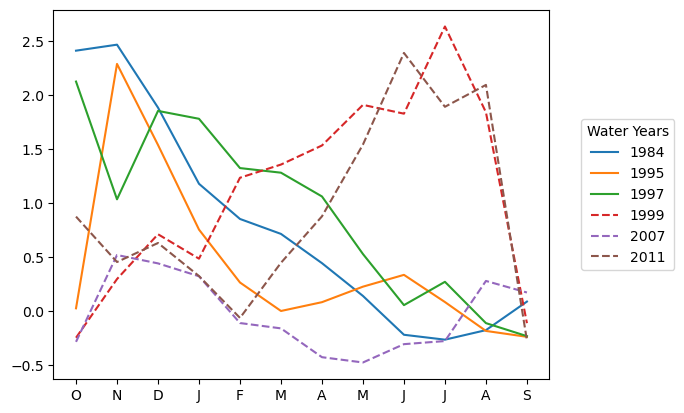

In [220]:
fig, ax = plt.subplots()
swea_cascades_ts.sel(time=slice('1984-10-01','1985-09-01')).to_pandas().reset_index().plot(y='swe_level2', ax=ax, label='1984')
swea_cascades_ts.sel(time=slice('1994-10-01','1995-09-01')).to_pandas().reset_index().plot(y='swe_level2', ax=ax, label='1995')
swea_cascades_ts.sel(time=slice('1996-10-01','1997-09-01')).to_pandas().reset_index().plot(y='swe_level2', ax=ax, label='1997')
swea_cascades_ts.sel(time=slice('1998-10-01','1999-09-01')).to_pandas().reset_index().plot(y='swe_level2', ax=ax, ls='--', label='1999')
swea_cascades_ts.sel(time=slice('2006-10-01','2007-09-01')).to_pandas().reset_index().plot(y='swe_level2', ax=ax, ls='--', label='2007')
swea_cascades_ts.sel(time=slice('2010-10-01','2011-09-01')).to_pandas().reset_index().plot(y='swe_level2', ax=ax, ls='--', label='2011')
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Water Years')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
plt.show()

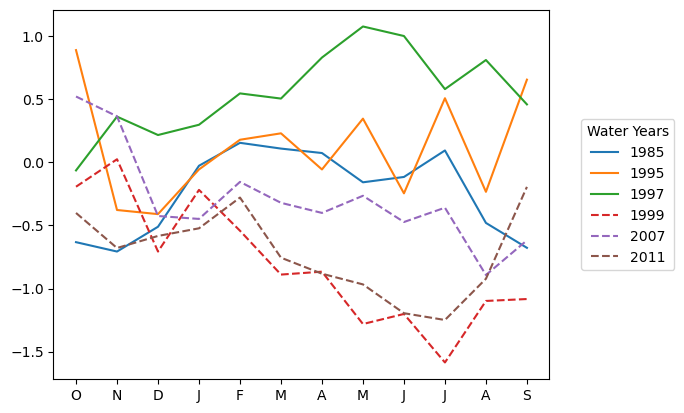

In [224]:
fig, ax = plt.subplots()
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1984-10-01','1985-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1985')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1994-10-01','1995-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1995')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1997')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax, ls='--',
                                                                                                               label='1999')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2006-10-01','2007-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax, ls='--',
                                                                                                               label='2007')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2010-10-01','2011-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax, ls='--',
                                                                                                               label='2011')
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Water Years')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
plt.show()

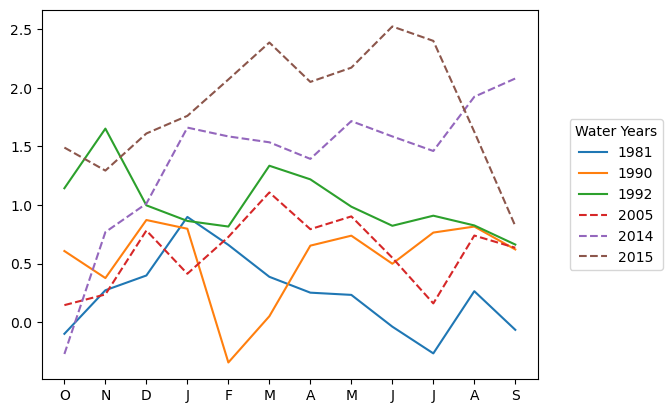

In [225]:
fig, ax = plt.subplots()
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1981')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1989-10-01','1990-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1990')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1991-10-01','1992-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1992')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax, ls='--',
                                                                                                               label='2005')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2013-10-01','2014-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax, ls='--',
                                                                                                               label='2014')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax, ls='--',
                                                                                                               label='2015')
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Water Years')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
plt.show()

In [222]:
df[df['swe_level2']<-1]

,time,sst,swe_level2,y_pred,dtime,AR-1,AR-3,AR-6,y_pred_l1,y_pred_l3,y_pred_l6
27,1981-01-01T00:00:00,0.898311,-1.493853,-0.288141,1981-01-01,1.051273,0.611869,0.521809,-0.376280,-0.354848,-0.306144
28,1981-02-01T00:00:00,0.659954,-1.481754,-0.198507,1981-02-01,1.668094,1.200253,0.749085,-0.287662,-0.279062,-0.241616
29,1981-03-01T00:00:00,0.387640,-1.496783,-0.096103,1981-03-01,0.815311,-0.187880,-0.395697,-0.186418,-0.192479,-0.167894
30,1981-04-01T00:00:00,0.252415,-1.070405,-0.045252,1981-04-01,0.297838,0.482170,-0.421002,-0.136143,-0.149483,-0.131286
134,1989-12-01T00:00:00,0.872062,-1.095837,-0.278270,1989-12-01,-0.337310,0.375585,1.032168,-0.366521,-0.346502,-0.299038
135,1990-01-01T00:00:00,0.797632,-1.057435,-0.250281,1990-01-01,-0.388516,0.435861,0.936618,-0.338849,-0.322837,-0.278888
161,1992-03-01T00:00:00,1.334928,-1.117003,-0.452330,1992-03-01,0.706667,0.318560,0.383967,-0.538609,-0.493672,-0.424346
162,1992-04-01T00:00:00,1.218742,-1.310713,-0.408639,1992-04-01,0.003270,0.485623,0.180457,-0.495413,-0.456730,-0.392892
316,2005-02-01T00:00:00,0.727522,-1.000821,-0.223916,2005-02-01,-1.446681,-1.056301,-1.414922,-0.312783,-0.300545,-0.259908
317,2005-03-01T00:00:00,1.107186,-1.144909,-0.366688,2005-03-01,-1.054274,-0.380538,-0.620867,-0.453937,-0.421261,-0.362691


<Axes: title={'center': 'CCM lag 1: R = 0.377 vs LinReg (r=0.453)'}, xlabel='dtime'>

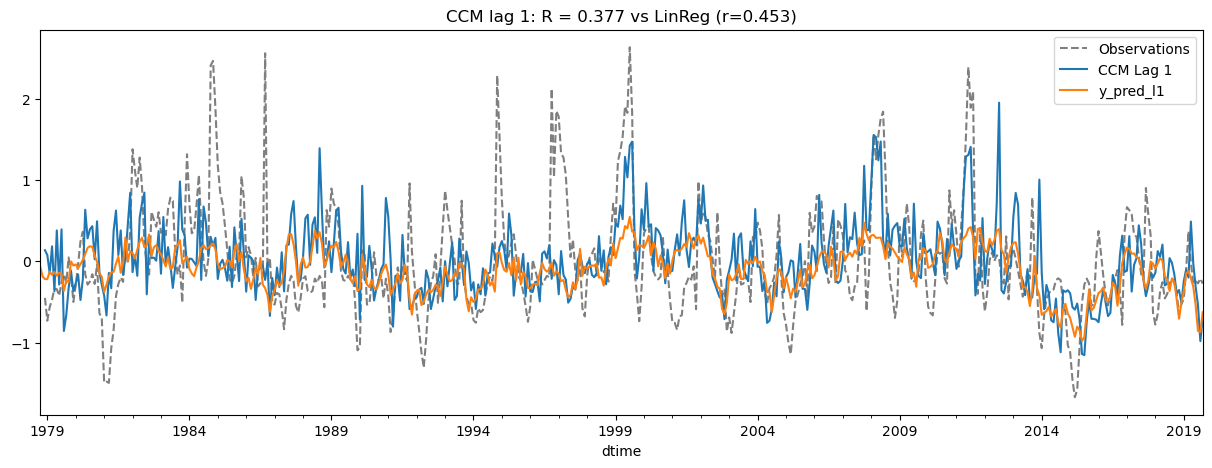

In [162]:
fig, ax = plt.subplots(figsize=(15,5))
ccm_lag1_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_lag1_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM Lag 1')

r1, p1 = stats.pearsonr(df['y_pred_l1'], df['swe_level2'])
r2, p2 = stats.pearsonr(ccm_lag1_re['Observations'], ccm_lag1_re['Predictions'])

ax.set_title('CCM lag 1: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
# df.plot(ax=ax, x='dtime', y='swe_level2')
df.plot(ax=ax, x='dtime', y='y_pred_l1')

<Axes: title={'center': 'CCM lag 3: R = 0.328 vs LinReg (r=0.453)'}, xlabel='dtime'>

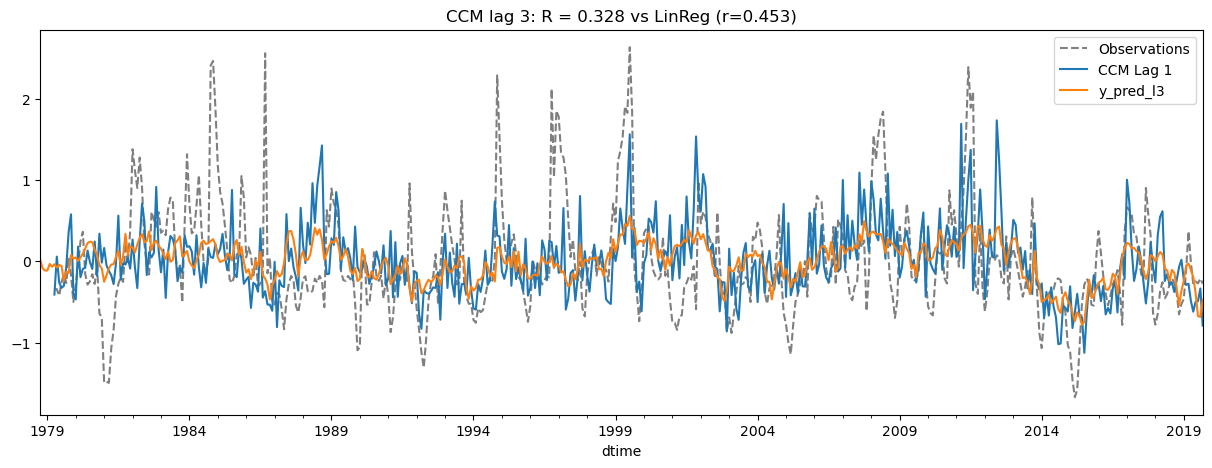

In [86]:
fig, ax = plt.subplots(figsize=(15,5))
ccm_lag3_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_lag3_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM Lag 1')
# df.plot(ax=ax, x='dtime', y='swe_level2')

r1, p1 = stats.pearsonr(df['y_pred_l3'], df['swe_level2'])
r2, p2 = stats.pearsonr(ccm_lag3_re['Observations'], ccm_lag3_re['Predictions'])

ax.set_title('CCM lag 3: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))

df.plot(ax=ax, x='dtime', y='y_pred_l3')

<Axes: title={'center': 'CCM lag 6: R = 0.363 vs LinReg (r=0.453)'}, xlabel='dtime'>

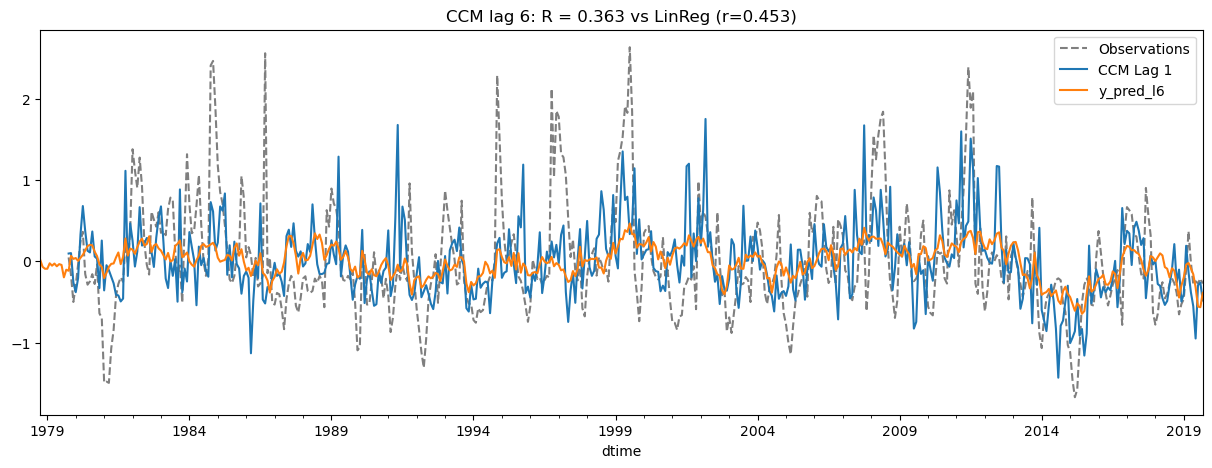

In [93]:
fig, ax = plt.subplots(figsize=(15,5))
ccm_lag6_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_lag6_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM Lag 1')
# df.plot(ax=ax, x='dtime', y='swe_level2')

r1, p1 = stats.pearsonr(df['y_pred_l6'], df['swe_level2'])
r2, p2 = stats.pearsonr(ccm_lag6_re['Observations'], ccm_lag6_re['Predictions'])

ax.set_title('CCM lag 6: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
df.plot(ax=ax, x='dtime', y='y_pred_l6')

In [140]:
ccm_lag6_re

,Time,Observations,Predictions,Pred_Variance,dtime
dtime,,,,,
1979-10-01,1979-10-01T00:00:00,0.048045,0.096206,0.032575,1979-10-01
1979-11-01,1979-11-01T00:00:00,-0.167057,0.101434,0.093235,1979-11-01
1979-12-01,1979-12-01T00:00:00,-0.500031,-0.258777,0.009584,1979-12-01
1980-01-01,1980-01-01T00:00:00,-0.294129,-0.380011,0.053536,1980-01-01
1980-02-01,1980-02-01T00:00:00,-0.038111,-0.206270,0.264783,1980-02-01
...,...,...,...,...,...
2019-05-01,2019-05-01T00:00:00,-0.279344,-0.552003,0.138576,2019-05-01
2019-06-01,2019-06-01T00:00:00,-0.245479,-0.950305,0.170623,2019-06-01
2019-07-01,2019-07-01T00:00:00,-0.271610,-0.293859,0.003976,2019-07-01


<Axes: xlabel='dtime'>

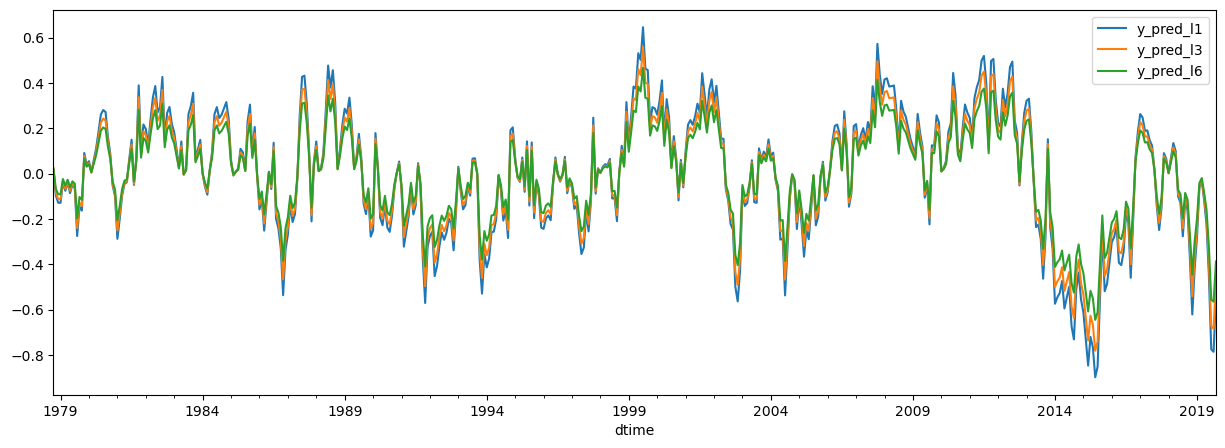

In [92]:
fig, ax = plt.subplots(figsize=(15,5))
df.plot(ax=ax, x='dtime', y='y_pred_l1')
df.plot(ax=ax, x='dtime', y='y_pred_l3')
df.plot(ax=ax, x='dtime', y='y_pred_l6')

In [ ]:


fig, ax = plt.subplots(figsize=(15,5))
ccm_lag1_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_lag1_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM Lag 1')
# df.plot(ax=ax, x='dtime', y='swe_level2')
df.plot(ax=ax, x='dtime', y='y_pred')

In [ ]:
df[2:]

In [29]:
ccm_lag1_re

,Time,Observations,Predictions,Pred_Variance
0,1978-12-01T00:00:00,-0.449708,0.136775,0.083483
1,1979-01-01T00:00:00,-0.730925,0.077885,0.515444
2,1979-02-01T00:00:00,-0.564041,-0.146861,0.138849
3,1979-03-01T00:00:00,-0.471018,0.184241,0.748725
4,1979-04-01T00:00:00,-0.336777,-0.368504,0.044091
...,...,...,...,...
485,2019-05-01T00:00:00,-0.279344,-0.023091,0.442647
486,2019-06-01T00:00:00,-0.245479,-0.311478,0.305018
487,2019-07-01T00:00:00,-0.271610,-0.538411,0.144455
488,2019-08-01T00:00:00,-0.211882,-0.982531,0.402723


In [30]:
from statsmodels.tsa.ar_model import AutoReg

train_data = ts[:400]
test_data = ts[400:]

ar_mod = AutoReg(train_data, lags=6)
trained_mod = ar_mod.fit()

In [31]:
coefs = trained_mod.params
sigma_e = np.sqrt(trained_mod.sigma2)

In [32]:
n = ts.shape[0]
sswe_ar1 = np.zeros(n)
sswe_ar3 = np.zeros(n)
sswe_ar6 = np.zeros(n)

In [33]:
sswe_ar1[0] = ts[0]
et = stats.norm.rvs(0,1,n)
mu = coefs[0]

for i in range(1,n):
    sswe_ar1[i] = coefs[0] + coefs[1]*(sswe_ar1[i-1]-coefs[0])+et[i]*sigma_e

In [34]:
sswe_ar3[0] = ts[0]
sswe_ar3[1] = ts[1]
sswe_ar3[2] = ts[2]

for i in range(3,n):
    sswe_ar3[i] = mu + coefs[1]*(sswe_ar1[i-3]-mu)+coefs[2]*(sswe_ar1[i-2]-mu)+coefs[3]*(sswe_ar1[i-1]-mu)+et[i]*sigma_e

In [35]:
sswe_ar6[0] = ts[0]
sswe_ar6[1] = ts[1]
sswe_ar6[2] = ts[2]
sswe_ar6[3] = ts[3]
sswe_ar6[4] = ts[4]
sswe_ar6[5] = ts[5]

for i in range(6,n):
    sswe_ar6[i] = mu + coefs[1]*(sswe_ar1[i-6]-mu)+coefs[2]*(sswe_ar1[i-5]-mu)+coefs[3]*(sswe_ar1[i-4]-mu)+coefs[4]*(sswe_ar1[i-3]-mu)+coefs[5]*(sswe_ar1[i-2]-mu)+coefs[6]*(sswe_ar1[i-1]-mu)+et[i]*sigma_e

In [36]:
df['AR-1'] = sswe_ar1
df['AR-3'] = sswe_ar3
df['AR-6'] = sswe_ar6

<Axes: xlabel='time'>

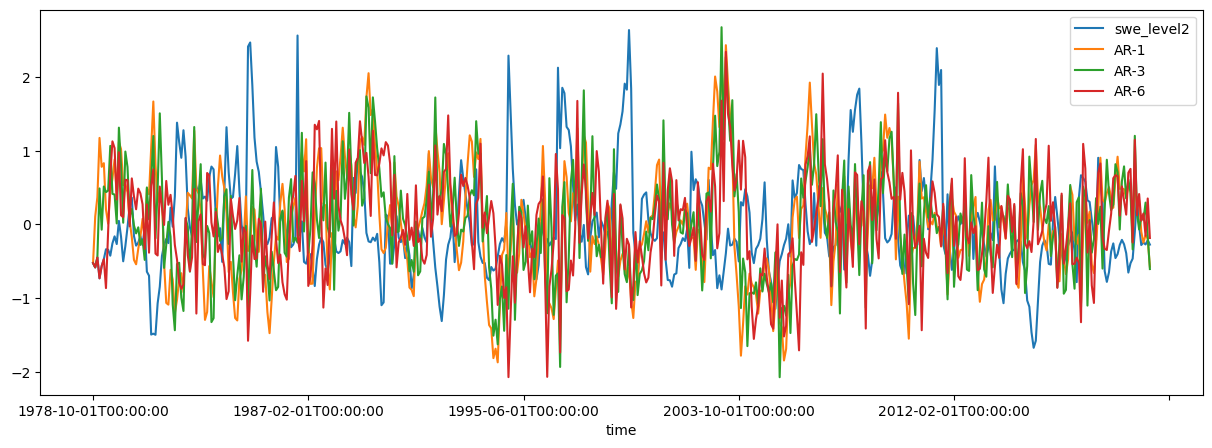

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
df.plot(ax=ax, x='time', y='swe_level2')
df.plot(ax=ax, x='time', y='AR-1')
df.plot(ax=ax, x='time', y='AR-3')
df.plot(ax=ax, x='time', y='AR-6')

<Axes: xlabel='Time'>

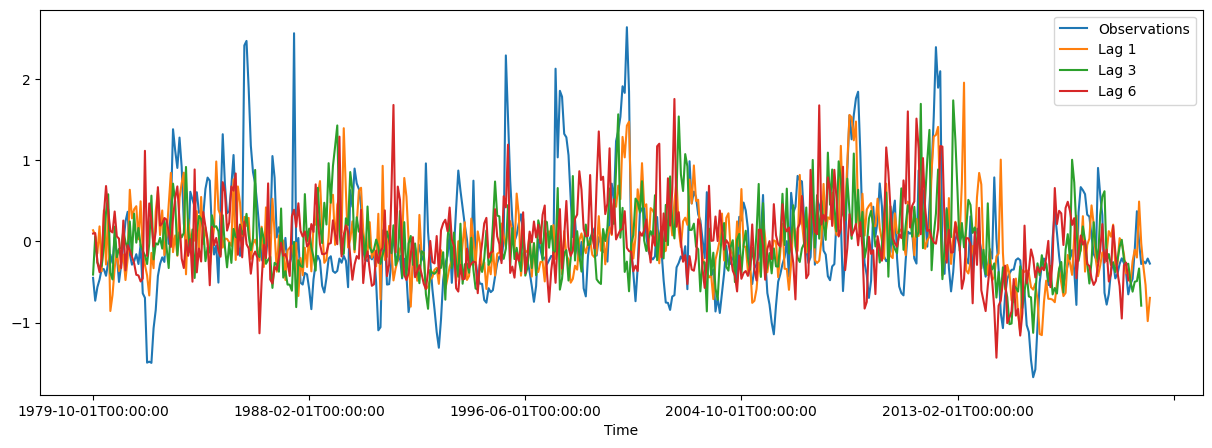

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
ccm_lag1_re.plot(ax=ax, x='Time', y='Observations')
ccm_lag1_re.plot(ax=ax, x='Time', y='Predictions', label='Lag 1')
ccm_lag3_re.plot(ax=ax, x='Time', y='Predictions', label='Lag 3')
ccm_lag6_re.plot(ax=ax, x='Time', y='Predictions', label='Lag 6')

In [39]:
df

,time,sst,swe_level2,y_pred,dtime,AR-1,AR-3,AR-6
0,1978-10-01T00:00:00,0.070282,-0.523846,0.023239,1978-10-01,-0.523846,-0.523846,-0.523846
1,1978-11-01T00:00:00,0.386935,-0.582581,-0.095838,1978-11-01,0.107579,-0.582581,-0.582581
2,1978-12-01T00:00:00,0.474465,-0.449708,-0.128754,1978-12-01,0.368313,-0.449708,-0.449708
3,1979-01-01T00:00:00,0.474786,-0.730925,-0.128875,1979-01-01,1.173862,0.488579,-0.730925
4,1979-02-01T00:00:00,0.226544,-0.564041,-0.035523,1979-02-01,0.781752,-0.071057,-0.564041
...,...,...,...,...,...,...,...,...
487,2019-05-01T00:00:00,0.724249,-0.279344,-0.222685,2019-05-01,-0.099214,0.102653,0.051274
488,2019-06-01T00:00:00,1.322131,-0.245479,-0.447518,2019-06-01,-0.247145,0.061193,0.149043
489,2019-07-01T00:00:00,2.194706,-0.271610,-0.775650,2019-07-01,-0.143789,0.296285,-0.155050
490,2019-08-01T00:00:00,2.224361,-0.211882,-0.786801,2019-08-01,-0.194877,-0.160804,0.352078


In [40]:
stats.pearsonr(df['swe_level2'], df['AR-1'])

PearsonRResult(statistic=-0.11808893383474695, pvalue=0.008745234590219761)

In [41]:
stats.pearsonr(df['swe_level2'], df['AR-3'])

PearsonRResult(statistic=-0.1463597942662569, pvalue=0.0011310998025354435)

In [42]:
stats.pearsonr(df['swe_level2'], df['AR-6'])

PearsonRResult(statistic=-0.14586593599206846, pvalue=0.0011761438381209886)

In [43]:
stats.pearsonr(ccm_lag1_re['Observations'], ccm_lag1_re['Predictions'])

PearsonRResult(statistic=0.3774328247707013, pvalue=4.899012221722124e-18)

In [44]:
stats.pearsonr(ccm_lag3_re['Observations'], ccm_lag3_re['Predictions'])

PearsonRResult(statistic=0.3281976419733781, pvalue=1.1430596052650148e-13)

In [45]:
stats.pearsonr(ccm_lag6_re['Observations'], ccm_lag6_re['Predictions'])

PearsonRResult(statistic=0.36251472523865946, pvalue=2.3593971962337487e-16)

In [46]:
ccm_lag1_re[ccm_lag1_re['Predictions']>1]

,Time,Observations,Predictions,Pred_Variance
116,1988-08-01T00:00:00,-0.178968,1.393574,0.290505
245,1999-05-01T00:00:00,1.910340,1.286661,1.280977
246,1999-06-01T00:00:00,1.828672,1.034169,1.185464
247,1999-07-01T00:00:00,2.637399,1.424884,0.698065
248,1999-08-01T00:00:00,1.841478,1.474727,0.870192
346,2007-10-01T00:00:00,0.258631,1.176321,1.173223
350,2008-02-01T00:00:00,1.552380,1.556574,0.027174
351,2008-03-01T00:00:00,1.256791,1.528844,0.073591
352,2008-04-01T00:00:00,1.555292,1.244279,0.167333
353,2008-05-01T00:00:00,1.760855,1.475875,0.016489


In [47]:
ccm_lag1_re[ccm_lag1_re['Predictions']<-0.7]

,Time,Observations,Predictions,Pred_Variance
8,1979-08-01T00:00:00,-0.161643,-0.858022,0.165047
133,1990-01-01T00:00:00,-1.057435,-0.714769,0.170360
147,1991-03-01T00:00:00,-0.688633,-0.804248,0.194666
287,2002-11-01T00:00:00,-0.347022,-0.711626,0.066345
305,2004-05-01T00:00:00,-0.525244,-0.757649,0.317509
306,2004-06-01T00:00:00,-0.331506,-0.732831,0.081776
425,2014-05-01T00:00:00,-0.350364,-0.726692,0.143490
426,2014-06-01T00:00:00,-0.347283,-0.749733,0.094590
428,2014-08-01T00:00:00,-0.209296,-0.891724,0.198188
429,2014-09-01T00:00:00,-0.232714,-1.119247,0.315659


Text(0, 0.5, 'SWE Anom. [-]')

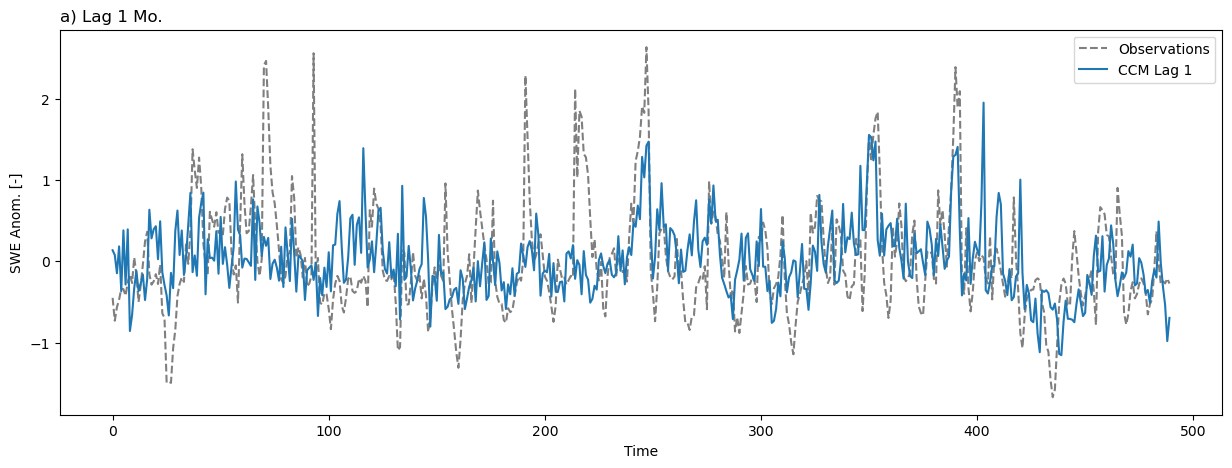

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
ccm_lag1_re.plot(ax=ax, y='Observations', ls='--', color='k', alpha=0.5)
ccm_lag1_re.plot(ax=ax, y='Predictions', label='CCM Lag 1')
# df.plot(ax=ax, x='dtime', y='AR-1', label='AR')
ax.set_title('a) Lag 1 Mo.', loc='left')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anom. [-]')
# ccm_lag3_re.plot(ax=ax, x='Time', y='Predictions', label='CCM Lag 3')
# ccm_lag6_re.plot(ax=ax, x='Time', y='Predictions', label='CCM Lag 6')

In [70]:
ccm_lag1_re['dtime'] = ccm_lag1_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_lag3_re['dtime'] = ccm_lag3_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_lag6_re['dtime'] = ccm_lag6_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))

In [71]:
df['dtime'] = df['time'].map(lambda x: datetime.datetime.fromisoformat(x))

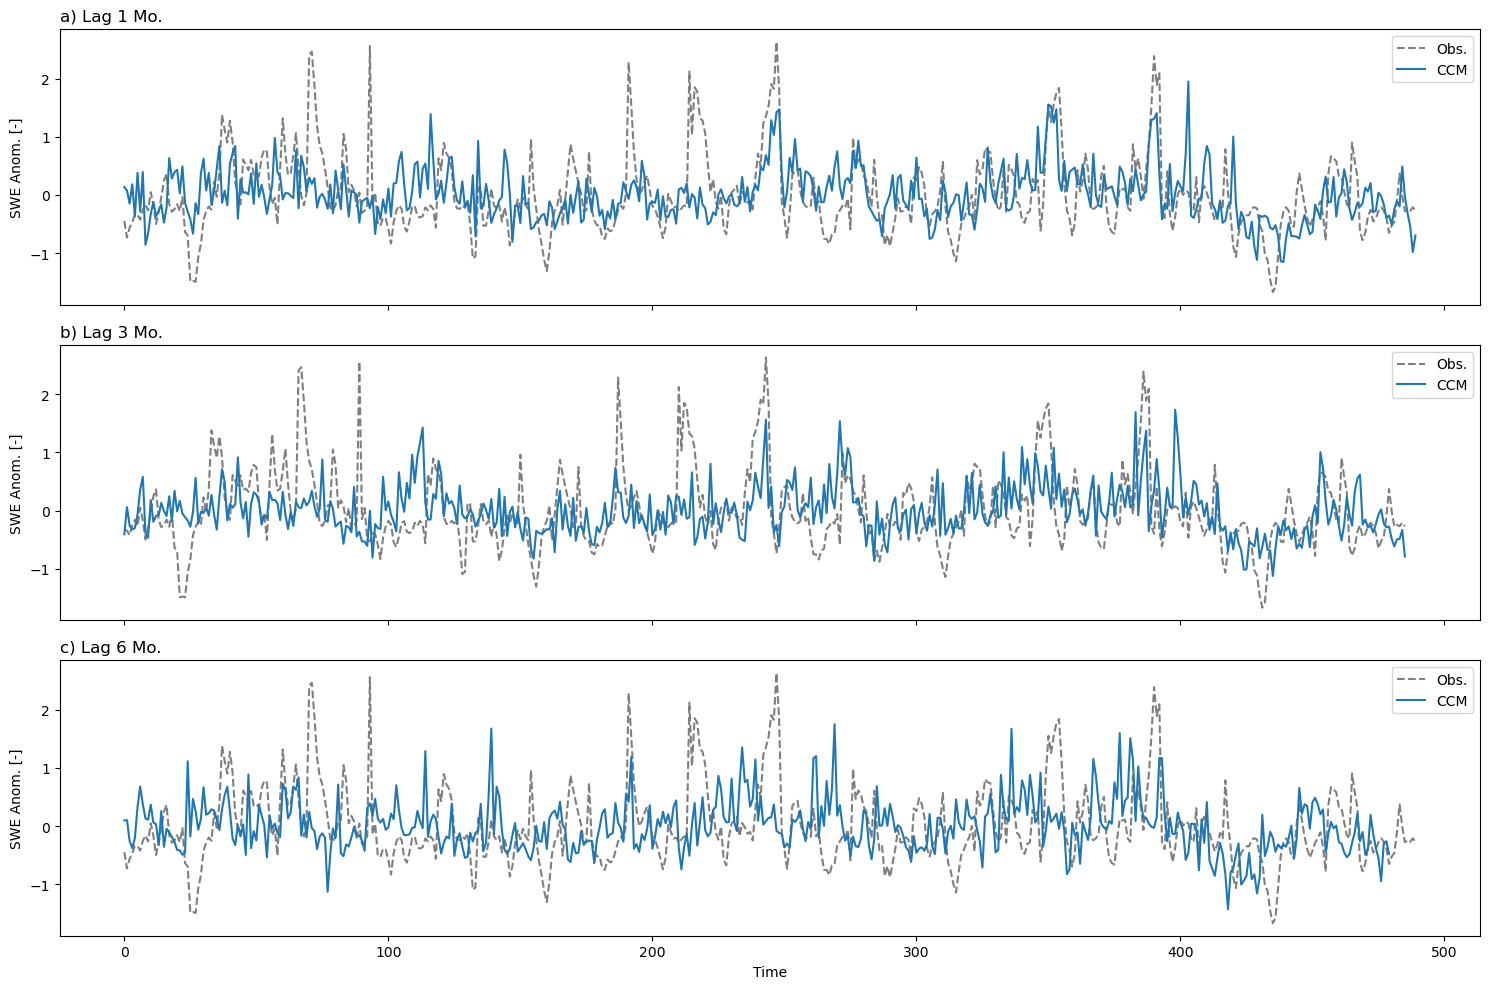

In [52]:
fig = plt.figure(figsize=(15,10))

gs = fig.add_gridspec(3,1)
ax1 = fig.add_subplot(gs[0])
ax3 = fig.add_subplot(gs[1], sharex=ax1)
ax6 = fig.add_subplot(gs[2], sharex=ax1)

ccm_lag1_re.plot(ax=ax1, y='Observations', ls='--', color='k', alpha=0.5,label='Obs.')
ccm_lag1_re.plot(ax=ax1, y='Predictions', label='CCM')

ccm_lag3_re.plot(ax=ax3, y='Observations', ls='--', color='k', alpha=0.5, label='Obs.')
ccm_lag3_re.plot(ax=ax3, y='Predictions', label='CCM')

ccm_lag1_re.plot(ax=ax6, y='Observations', ls='--', color='k', alpha=0.5, label='Obs.')
ccm_lag6_re.plot(ax=ax6, y='Predictions', label='CCM')
plt.tight_layout()

# fig, ax = plt.subplots(figsize=(15,5))
# ax11 = fig.add_subplot(gs[0])
# df.plot(ax=ax11, x='time', y='swe_level2', ls='--', color='k', alpha=0.5, label='Obs.', legend=False)
# df.plot(ax=ax1, x='dtime', y='AR-1', label='AR')

# ax31 = fig.add_subplot(gs[1,1])
# df.plot(ax=ax3, x='dtime', y='AR-3', label='AR')
# df.plot(ax=ax3, x='time', y='swe_level2', ls='--', color='k', alpha=0.5, label='Obs.', legend=False)


# ax61 = fig.add_subplot(gs[2,1])
# df.plot(ax=ax6, x='dtime', y='AR-6', label='AR')
# df.plot(ax=ax6, x='time', y='swe_level2', ls='--', color='k', alpha=0.5, label='Obs.', legend=False)

# df.plot(ax=ax, x='time', y='AR-3')
# df.plot(ax=ax, x='time', y='AR-6')
ax1.set_title('a) Lag 1 Mo.', loc='left')
ax3.set_title('b) Lag 3 Mo.', loc='left')
ax6.set_title('c) Lag 6 Mo.', loc='left')

ax6.set_xlabel('Time')
ax1.set_ylabel('SWE Anom. [-]')
ax3.set_ylabel('SWE Anom. [-]')
ax6.set_ylabel('SWE Anom. [-]')

plt.tight_layout()

In [53]:
sst_ref = df[['time', 'sst']]
sst_ref['dtime'] = sst_ref['time'].map(lambda x: datetime.datetime.fromisoformat(x))

In [54]:
sst_ref.drop(['time'], axis=1, inplace=True)

In [55]:
sst_ref.set_index('dtime', inplace=True)

In [56]:
sst_ref

,sst
dtime,
1978-10-01,0.070282
1978-11-01,0.386935
1978-12-01,0.474465
1979-01-01,0.474786
1979-02-01,0.226544
...,...
2019-05-01,0.724249
2019-06-01,1.322131
2019-07-01,2.194706


In [57]:
ccm_lag1_re['dtime'] = ccm_lag1_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_lag1_re.set_index('dtime', inplace=True)

In [58]:
ccm_lag3_re['dtime'] = ccm_lag3_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_lag3_re.set_index('dtime', inplace=True)

In [59]:
ccm_lag6_re['dtime'] = ccm_lag6_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_lag6_re.set_index('dtime', inplace=True)

In [60]:
ccm_lag1_re[ccm_lag1_re['Predictions']>1]

,Time,Observations,Predictions,Pred_Variance
dtime,,,,
1988-08-01,1988-08-01T00:00:00,-0.178968,1.393574,0.290505
1999-05-01,1999-05-01T00:00:00,1.910340,1.286661,1.280977
1999-06-01,1999-06-01T00:00:00,1.828672,1.034169,1.185464
1999-07-01,1999-07-01T00:00:00,2.637399,1.424884,0.698065
1999-08-01,1999-08-01T00:00:00,1.841478,1.474727,0.870192
2007-10-01,2007-10-01T00:00:00,0.258631,1.176321,1.173223
2008-02-01,2008-02-01T00:00:00,1.552380,1.556574,0.027174
2008-03-01,2008-03-01T00:00:00,1.256791,1.528844,0.073591
2008-04-01,2008-04-01T00:00:00,1.555292,1.244279,0.167333


<Axes: >

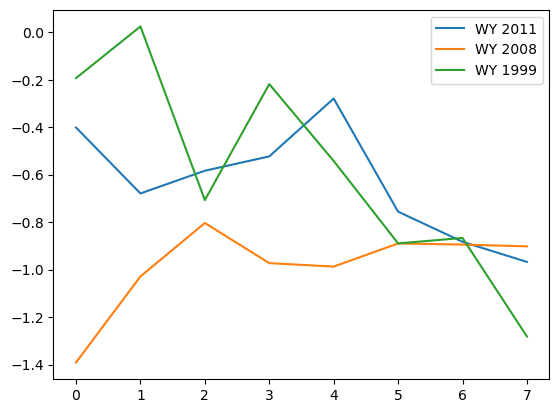

In [61]:
fig, ax = plt.subplots()
sst_ref.loc['2010-10-01':'2011-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 2011')
sst_ref.loc['2007-10-01':'2008-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 2008')
sst_ref.loc['1998-10-01':'1999-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 1999')

In [62]:
ccm_lag1_re[ccm_lag1_re['Predictions']<-0.7]

,Time,Observations,Predictions,Pred_Variance
dtime,,,,
1979-08-01,1979-08-01T00:00:00,-0.161643,-0.858022,0.165047
1990-01-01,1990-01-01T00:00:00,-1.057435,-0.714769,0.170360
1991-03-01,1991-03-01T00:00:00,-0.688633,-0.804248,0.194666
2002-11-01,2002-11-01T00:00:00,-0.347022,-0.711626,0.066345
2004-05-01,2004-05-01T00:00:00,-0.525244,-0.757649,0.317509
2004-06-01,2004-06-01T00:00:00,-0.331506,-0.732831,0.081776
2014-05-01,2014-05-01T00:00:00,-0.350364,-0.726692,0.143490
2014-06-01,2014-06-01T00:00:00,-0.347283,-0.749733,0.094590
2014-08-01,2014-08-01T00:00:00,-0.209296,-0.891724,0.198188


<Axes: >

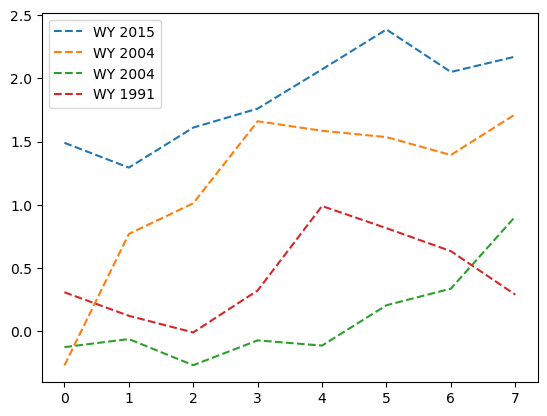

In [63]:
fig, ax = plt.subplots()
sst_ref.loc['2014-10-01':'2015-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 2015', ls='--')
sst_ref.loc['2013-10-01':'2014-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 2004', ls='--')
sst_ref.loc['2003-10-01':'2004-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 2004', ls='--')
sst_ref.loc['1990-10-01':'1991-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 1991', ls='--')

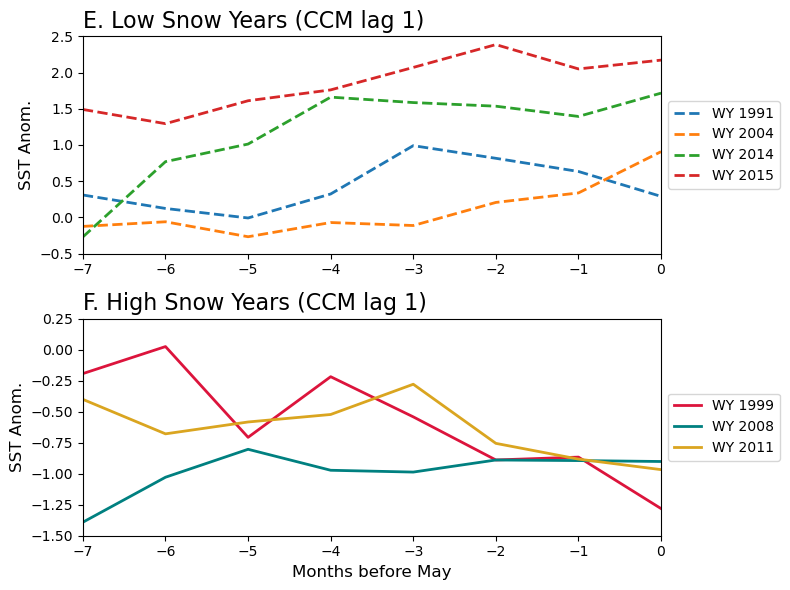

In [97]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0])
ax1.plot(np.arange(0,-8,-1)[::-1], sst_ref.loc['1990-10-01':'1991-05-01','sst'], label='WY 1991', ls='--', lw=2)
ax1.plot(np.arange(0,-8,-1)[::-1], sst_ref.loc['2003-10-01':'2004-05-01','sst'], label='WY 2004', ls='--', lw=2)
ax1.plot(np.arange(0,-8,-1)[::-1], sst_ref.loc['2013-10-01':'2014-05-01','sst'], label='WY 2014', ls='--', lw=2)
ax1.plot(np.arange(0,-8,-1)[::-1], sst_ref.loc['2014-10-01':'2015-05-01','sst'], label='WY 2015', ls='--', lw=2)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5))

ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(np.arange(0,-8,-1)[::-1], sst_ref.loc['1998-10-01':'1999-05-01','sst'], label='WY 1999', color='crimson', lw=2)
ax2.plot(np.arange(0,-8,-1)[::-1], sst_ref.loc['2007-10-01':'2008-05-01','sst'], label='WY 2008', color='teal', lw=2)
ax2.plot(np.arange(0,-8,-1)[::-1], sst_ref.loc['2010-10-01':'2011-05-01','sst'], label='WY 2011', color='goldenrod', lw=2)
ax2.legend(loc='center left', bbox_to_anchor=(1,0.5))

ax1.set_ylabel('SST Anom.', fontsize=12)
ax2.set_ylabel('SST Anom.', fontsize=12)
ax2.set_xlabel('Months before May', fontsize=12)
ax1.set_title('E. Low Snow Years (CCM lag 1)', loc='left', fontsize=16)
ax2.set_title('F. High Snow Years (CCM lag 1)', loc='left', fontsize=16)

ax1.axis([-7,0,-0.5,2.5])
ax2.axis([-7,0,-1.5,0.25])

plt.tight_layout()
plt.savefig('./gsa_panel_d.svg', bbox_inches='tight', facecolor='w', dpi=300)



In [ ]:
sst_ref.loc['2010-10-01':'2011-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 2011')
sst_ref.loc['2007-10-01':'2008-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 2008')
sst_ref.loc['1998-10-01':'1999-05-01'].reset_index().plot(ax=ax, y='sst', label='WY 1999')

In [165]:
sst

,sst
time,
1963-10-01,-0.531098
1963-11-01,-1.433966
1963-12-01,-0.507828
1964-01-01,-0.363402
1964-02-01,-0.243203
...,...
2019-05-01,0.724249
2019-06-01,1.322131
2019-07-01,2.194706


<xarray.DataArray 'sst' (time: 672)>
array([-0.53109807, -1.4339662 , -0.50782835, -0.3634015 , -0.2432031 ,
       -0.27084363, -0.1452541 , -0.63070416, -0.16221505, -0.64626145,
       -1.0510371 , -0.6822071 , -0.33287656, -0.47212565, -0.20088865,
       -0.76630104, -0.41253048,  0.12453637,  0.0099035 , -0.24202909,
       -0.03436147,  0.6603489 , -0.01146102, -0.15501931,  0.04607177,
        0.05601099, -0.28611702, -0.6778272 , -0.8573352 , -0.68539673,
       -0.22943068, -0.12558259,  0.11004373, -0.41429797, -0.26833916,
       -0.46141303, -0.41321555, -0.3437411 , -0.2303266 , -0.40068117,
       -0.3990294 , -0.4082508 , -1.039705  , -0.5925629 ,  0.16888945,
        0.6442558 ,  1.8133475 ,  0.93595916, -0.29505682,  0.03581434,
       -1.0116181 , -0.80085343, -0.8022627 , -0.36689913, -0.43976915,
        0.30626953,  0.07049961,  0.22692806,  0.11450071, -0.19539165,
       -0.63998175, -0.49335834, -0.55188864, -0.9919066 , -1.374143  ,
       -1.1112456 , -1.0438695 , -0.6525066 ,  0.26690593, -0.03566069,
       -0.7645447 , -0.57475686, -0.368465  , -0.5793803 ,  0.12676336,
       -0.20437177,  0.04169516,  0.04179952,  0.04205675, -0.20078722,
       -0.012863  , -0.23669662, -0.6488168 , -0.7630132 , -0.51633865,
       -0.13259298, -0.70052475, -0.97108567, -0.6454489 , -0.76126236,
       -0.82087994, -0.91444504, -0.55168235, -0.70503736, -0.45281208,
       -1.9093785 , -1.9106007 , -1.372194  , -0.86022705, -0.96576047,
...
       -0.19469254, -1.1892203 , -1.2133905 , -0.7269759 , -0.46222782,
       -0.4166946 , -0.864383  , -0.6442003 , -0.8118274 , -1.1204484 ,
       -1.1822346 , -0.49039352, -0.34846032,  0.27121654, -0.22697547,
       -0.5762578 , -0.72356075, -0.74692476, -0.36803016,  0.21970724,
        0.7605311 ,  0.7296633 ,  0.90209335,  1.3658311 ,  0.8728    ,
       -0.27063403,  0.76897556,  1.0119222 ,  1.6601169 ,  1.5850282 ,
        1.5348902 ,  1.393338  ,  1.7154386 ,  1.5848699 ,  1.4606397 ,
        1.9232398 ,  2.078995  ,  1.4898766 ,  1.2934977 ,  1.6101282 ,
        1.7601558 ,  2.0704186 ,  2.385836  ,  2.0498934 ,  2.1714435 ,
        2.5226023 ,  2.399827  ,  1.6241461 ,  0.8204552 ,  1.513162  ,
        1.4267126 ,  1.1829107 ,  0.9365384 ,  0.87705517,  0.75004697,
        1.1783919 ,  1.2067912 ,  1.050907  ,  0.5956178 ,  0.70929384,
        1.3553396 ,  0.69484735, -0.05043083, -0.35540098, -0.5663712 ,
       -0.5270255 , -0.3694713 , -0.37499374, -0.25944003, -0.19684182,
        0.07886574,  0.51466954,  0.79467905,  0.53514963, -0.10758421,
       -0.04011186,  0.12681514, -0.05412759, -0.22607501, -0.12976421,
        0.39929026,  0.4746436 ,  0.868926  ,  0.45254475,  0.56491065,
        1.1374334 ,  1.7863917 ,  1.2431481 ,  0.8683837 ,  0.29055503,
        0.21122545,  0.44975865,  0.7242492 ,  1.3221306 ,  2.1947062 ,
        2.2243614 ,  1.5721335 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2019-09-01